Mout Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset Location

In [ ]:
!ls "/content/drive/MyDrive/Dataset Eye"

eye.zip


Extract ZIP Dataset

In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Dataset Eye/eye.zip"
extract_path = "/content/EyeDataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)


Files extracted to: /content/EyeDataset


Spilt Train , Test , Valid

In [ ]:
import random
import shutil

data_dir = os.path.join(extract_path, 'dataset')

base_dir = "/content/EyeDataset_split"
train_dir = os.path.join(base_dir, 'train')
val_dir   = os.path.join(base_dir, 'val')
test_dir  = os.path.join(base_dir, 'test')

for folder in [train_dir, val_dir, test_dir]:
    for cls in ['cataract','diabetic_retinopathy','glaucoma','normal']:
        os.makedirs(os.path.join(folder, cls), exist_ok=True)

def split_data(source_dir, train_dir, val_dir, test_dir, split_ratio=(0.8,0.1,0.1)):
    for cls in os.listdir(source_dir):
        cls_path = os.path.join(source_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        images = os.listdir(cls_path)
        random.shuffle(images)

        n = len(images)
        n_train = int(0.8 * n)
        n_val   = int(0.1 * n)

        for i, img in enumerate(images):
            src = os.path.join(cls_path, img)
            if i < n_train:
                dst = os.path.join(train_dir, cls, img)
            elif i < n_train + n_val:
                dst = os.path.join(val_dir, cls, img)
            else:
                dst = os.path.join(test_dir, cls, img)
            shutil.copy(src, dst)

split_data(data_dir, train_dir, val_dir, test_dir)
print("Dataset split completed.")


Dataset split completed.


Import Libraries & Device Setup

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Data Augmentation

In [ ]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


Loader

In [ ]:
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

classes = train_dataset.classes
print("Classes:", classes)


Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


Attention Block

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.fc1 = nn.Linear(c, c//16)
        self.fc2 = nn.Linear(c//16, c)

    def forward(self, x):
        b,c,_,_ = x.size()
        y = x.view(b,c,-1).mean(dim=2)
        y = torch.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y))
        return x * y.view(b,c,1,1)


Packages

In [ ]:
!pip install torch torchvision torchaudio --upgrade
!pip install efficientnet_pytorch

Model (Efficient Net)

In [ ]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b2')

classes = ['cataract','diabetic_retinopathy','glaucoma','normal'] # Define the classes here
num_classes = len(classes)
in_features = model._fc.in_features
model._fc = nn.Linear(in_features, num_classes)

model = model.to(device)

Loaded pretrained weights for efficientnet-b2


Loss & Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

Training Loop

In [ ]:
num_epochs = 60        # max epochs
patience = 7           # wait this many epochs for improvement
best_val_loss = float('inf')  # start with infinity
counter = 0            # counts epochs without improvement


In [ ]:

# ---------- Initialize ----------
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_loss = float('inf')  # best validation loss
patience = 7                  # early stopping patience
counter = 0                   # epochs without improvement
save_path = "/content/drive/MyDrive/eye_efficientnet_b2_best.pth"

# ---------- Training Loop ----------
for epoch in range(num_epochs):
    start = time.time()

    # -------- Training --------
    model.train()
    correct, total, loss_sum = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * imgs.size(0)
        correct += (out.argmax(1) == labels).sum().item()
        total += labels.size(0)

    train_loss = loss_sum / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # -------- Validation --------
    model.eval()
    correct, total, loss_sum = 0, 0, 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            loss = criterion(out, labels)

            loss_sum += loss.item() * imgs.size(0)
            correct += (out.argmax(1) == labels).sum().item()
            total += labels.size(0)

    val_loss = loss_sum / total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # -------- Early Stopping Check --------
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), save_path)  # save best weights
        print("✅ Best model saved!")
    else:
        counter += 1
        if counter >= patience:
            print(f"⏹️ Early stopping triggered at epoch {epoch+1}")
            break

    # -------- Epoch Summary --------
    print(
        f"Epoch [{epoch+1}/{num_epochs}] | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
        f"Time: {time.time()-start:.1f}s"
    )


✅ Best model saved!
Epoch [1/60] | Train Loss: 0.7249, Train Acc: 0.7706 | Val Loss: 0.4820, Val Acc: 0.8246 | Time: 104.5s
✅ Best model saved!
Epoch [2/60] | Train Loss: 0.2796, Train Acc: 0.9012 | Val Loss: 0.1897, Val Acc: 0.9342 | Time: 100.2s
✅ Best model saved!
Epoch [3/60] | Train Loss: 0.2056, Train Acc: 0.9262 | Val Loss: 0.1069, Val Acc: 0.9632 | Time: 99.8s
✅ Best model saved!
Epoch [4/60] | Train Loss: 0.1748, Train Acc: 0.9360 | Val Loss: 0.0845, Val Acc: 0.9728 | Time: 100.7s
✅ Best model saved!
Epoch [5/60] | Train Loss: 0.1457, Train Acc: 0.9434 | Val Loss: 0.0595, Val Acc: 0.9789 | Time: 99.1s
Epoch [6/60] | Train Loss: 0.1262, Train Acc: 0.9544 | Val Loss: 0.0633, Val Acc: 0.9798 | Time: 99.7s
✅ Best model saved!
Epoch [7/60] | Train Loss: 0.1007, Train Acc: 0.9623 | Val Loss: 0.0292, Val Acc: 0.9868 | Time: 98.6s
✅ Best model saved!
Epoch [8/60] | Train Loss: 0.0794, Train Acc: 0.9706 | Val Loss: 0.0233, Val Acc: 0.9930 | Time: 99.7s
Epoch [9/60] | Train Loss: 0.0648

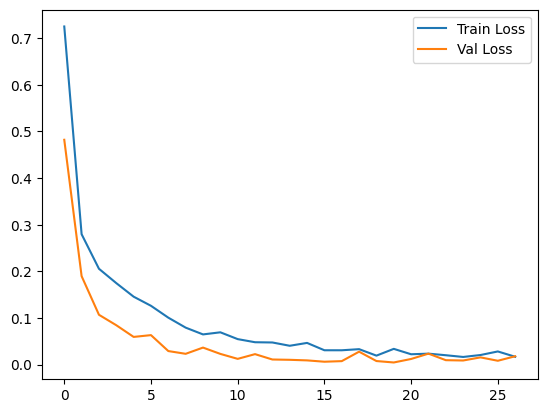

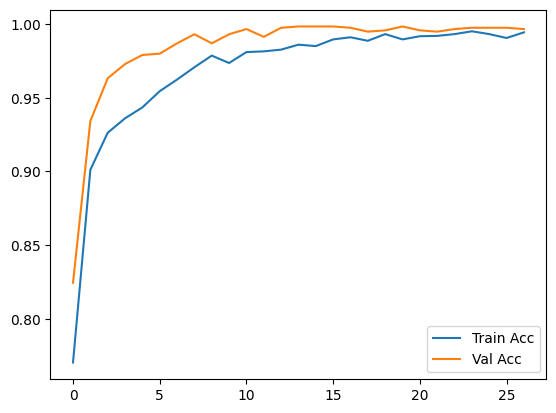

In [ ]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.show()

plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.show()


Testing

In [ ]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F

# ================= CONFIGURATION =================
MODEL_PATH = "/content/drive/MyDrive/eye_efficientnet_b2_best.pth"
class_names = ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# =================================================

# 1. Attention Block
class SEBlock(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.fc1 = nn.Linear(c, c//16)
        self.fc2 = nn.Linear(c//16, c)

    def forward(self, x):
        b,c,_,_ = x.size()
        y = x.view(b,c,-1).mean(dim=2)
        y = torch.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y))
        return x * y.view(b,c,1,1)

# 2. Wrapper Class
class EyeDiseaseModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = EfficientNet.from_name('efficientnet-b2')
        in_features = self.backbone._fc.in_features
        self.attn = SEBlock(in_features)
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.backbone.extract_features(x)
        x = self.attn(x)
        x = self.backbone._avg_pooling(x)
        x = x.flatten(start_dim=1)
        x = self.backbone._dropout(x)
        x = self.fc(x)
        return x

# 3. LOADING FUNCTION (Fixed with strict=False)
def load_exact_model():
    print(f"⏳ Loading Custom Eye Model from {MODEL_PATH}...")

    model = EyeDiseaseModel(num_classes=len(class_names))

    try:
        state_dict = torch.load(MODEL_PATH, map_location=device)

        # --- THE FIX: strict=False ---
        # This tells PyTorch: "It is okay if backbone._fc is missing, we don't use it."
        model.load_state_dict(state_dict, strict=False)

        model.to(device)
        model.eval()
        print("✅ Success! Custom Model loaded .")
        return model
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# Load it
eye_model = load_exact_model()

# ================= PREDICTION FUNCTION =================
def predict_eye_disease(image_path):
    if eye_model is None: return

    # Preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    try:
        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = eye_model(img_tensor)
            probs = F.softmax(outputs, dim=1)
            confidence, predicted_idx = torch.max(probs, 1)

            confidence_score = confidence.item() * 100
            predicted_class = class_names[predicted_idx.item()]

        print("-" * 30)
        print(f"👁️ Image: {image_path.split('/')[-1]}")
        print(f"🩺 Prediction: {predicted_class}")
        print(f"📊 Confidence: {confidence_score:.2f}%")
        print("-" * 30)
        return predicted_class, confidence_score

    except Exception as e:
        print(f"❌ Prediction Error: {e}")

⏳ Loading Custom Eye Model from /content/drive/MyDrive/eye_efficientnet_b2_best.pth...
✅ Success! Custom Model loaded .


In [ ]:
# ================= TEST IT =================
test_img = "/content/c1.png"
predict_eye_disease(test_img)

------------------------------
👁️ Image: c1.png
🩺 Prediction: Glaucoma
📊 Confidence: 99.91%
------------------------------


('Glaucoma', 99.91267323493958)

In [ ]:
# ================= TEST IT =================
test_img = "/content/c.png"
predict_eye_disease(test_img)

------------------------------
👁️ Image: c.png
🩺 Prediction: Cataract
📊 Confidence: 97.39%
------------------------------


('Cataract', 97.38561511039734)

In [ ]:
# ================= TEST IT =================
test_img = "/content/g.png"
predict_eye_disease(test_img)

------------------------------
👁️ Image: g.png
🩺 Prediction: Glaucoma
📊 Confidence: 99.98%
------------------------------


('Glaucoma', 99.98434782028198)

In [ ]:
# ================= TEST IT =================
test_img = "/content/n.png"
predict_eye_disease(test_img)

------------------------------
👁️ Image: n.png
🩺 Prediction: Normal
📊 Confidence: 100.00%
------------------------------


('Normal', 99.99988079071045)

In [ ]:
# ================= TEST IT =================
test_img = "/content/c.png"
predict_eye_disease(test_img)


------------------------------
👁️ Image: c.png
🩺 Prediction: Cataract
📊 Confidence: 97.39%
------------------------------


('Cataract', 97.38561511039734)

In [ ]:
# ================= TEST IT =================
test_img = "/content/c1.jpg"
predict_eye_disease(test_img)

------------------------------
👁️ Image: c1.jpg
🩺 Prediction: Cataract
📊 Confidence: 99.30%
------------------------------


('Cataract', 99.30039048194885)

In [ ]:
# ================= TEST IT =================
test_img = "/content/c2.jpg"
predict_eye_disease(test_img)

------------------------------
👁️ Image: c2.jpg
🩺 Prediction: Cataract
📊 Confidence: 100.00%
------------------------------


('Cataract', 99.9976634979248)

In [ ]:
# ================= TEST IT =================
test_img = "/content/g_net1.jpg"
predict_eye_disease(test_img)

------------------------------
👁️ Image: g_net1.jpg
🩺 Prediction: Glaucoma
📊 Confidence: 99.93%
------------------------------


('Glaucoma', 99.92650151252747)

In [ ]:
# ================= TEST IT =================
test_img = "/content/g_net2.jpg"
predict_eye_disease(test_img)

In [ ]:
# ================= TEST IT =================
test_img = "/content/g_net.jpg"
predict_eye_disease(test_img)

------------------------------
👁️ Image: g_net.jpg
🩺 Prediction: Glaucoma
📊 Confidence: 99.31%
------------------------------


('Glaucoma', 99.30705428123474)

In [ ]:
# ================= TEST IT =================
test_img = "/content/n.jpg"
predict_eye_disease(test_img)

------------------------------
👁️ Image: n.jpg
🩺 Prediction: Normal
📊 Confidence: 100.00%
------------------------------


('Normal', 99.99970197677612)

In [ ]:
# ================= TEST IT =================
test_img = "/content/c.jpg"
predict_eye_disease(test_img)

------------------------------
👁️ Image: c.jpg
🩺 Prediction: Cataract
📊 Confidence: 99.91%
------------------------------


('Cataract', 99.90697503089905)

In [ ]:
# ================= TEST IT =================
test_img = "/content/c1.jpg"
predict_eye_disease(test_img)

------------------------------
👁️ Image: c1.jpg
🩺 Prediction: Cataract
📊 Confidence: 99.30%
------------------------------


('Cataract', 99.30039048194885)

In [ ]:
# ================= TEST IT =================
test_img = "/content/c_seg_data.jpg"
predict_eye_disease(test_img)

------------------------------
👁️ Image: c_seg_data.jpg
🩺 Prediction: Cataract
📊 Confidence: 85.27%
------------------------------


('Cataract', 85.26806235313416)

In [ ]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F

# ================= CONFIGURATION =================
MODEL_PATH = "/content/drive/MyDrive/eye_efficientnet_b2_best.pth"
class_names = ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Normal']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# =================================================

# 1. Attention Block
class SEBlock(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.fc1 = nn.Linear(c, c//16)
        self.fc2 = nn.Linear(c//16, c)

    def forward(self, x):
        b,c,_,_ = x.size()
        y = x.view(b,c,-1).mean(dim=2)
        y = torch.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y))
        return x * y.view(b,c,1,1)

# 2. Wrapper Class
class EyeDiseaseModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = EfficientNet.from_name('efficientnet-b2')
        in_features = self.backbone._fc.in_features
        self.attn = SEBlock(in_features)
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.backbone.extract_features(x)
        x = self.attn(x)
        x = self.backbone._avg_pooling(x)
        x = x.flatten(start_dim=1)
        x = self.backbone._dropout(x)
        x = self.fc(x)
        return x

# 3. LOADING FUNCTION (Fixed with strict=False)
def load_exact_model():
    print(f"⏳ Loading Custom Eye Model from {MODEL_PATH}...")

    model = EyeDiseaseModel(num_classes=len(class_names))

    try:
        state_dict = torch.load(MODEL_PATH, map_location=device)

        # --- THE FIX: strict=False ---
        # This tells PyTorch: "It is okay if backbone._fc is missing, we don't use it."
        model.load_state_dict(state_dict, strict=False)

        model.to(device)
        model.eval()
        print("✅ Success! Custom Model loaded (ignored unused backbone._fc layer).")
        return model
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

# Load it
eye_model = load_exact_model()

# ================= PREDICTION FUNCTION =================
def predict_eye_disease(image_path):
    if eye_model is None: return

    # Preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    try:
        img = Image.open(image_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = eye_model(img_tensor)
            probs = F.softmax(outputs, dim=1)
            confidence, predicted_idx = torch.max(probs, 1)

            confidence_score = confidence.item() * 100
            predicted_class = class_names[predicted_idx.item()]

        print("-" * 30)
        print(f"👁️ Image: {image_path.split('/')[-1]}")
        print(f"🩺 Prediction: {predicted_class}")
        print(f"📊 Confidence: {confidence_score:.2f}%")
        print("-" * 30)
        return predicted_class, confidence_score

    except Exception as e:
        print(f"❌ Prediction Error: {e}")

⏳ Loading Custom Eye Model from /content/drive/MyDrive/eye_efficientnet_b2_best.pth...
❌ Error: [Errno 2] No such file or directory: '/content/drive/MyDrive/eye_efficientnet_b2_best.pth'


In [ ]:
# ================= TEST IT =================
test_img = "/content/IMG_4140.jpg"
predict_eye_disease(test_img)

------------------------------
👁️ Image: IMG_4140.jpg
🩺 Prediction: Cataract
📊 Confidence: 99.94%
------------------------------


('Cataract', 99.93914365768433)

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_dir = "/content/EyeDataset_split/test"   # change if needed

test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


NameError: name 'transforms' is not defined

In [ ]:
import numpy as np

y_true, y_pred, y_prob = [], [], []

eye_model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = eye_model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_prob.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

print("✅ Inference completed on test set")


✅ Inference completed on test set


Confusion Matrix


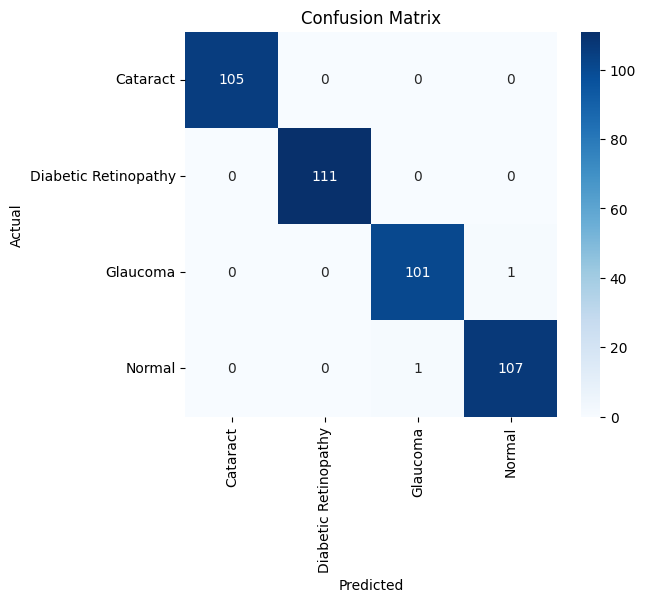

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Precision, Recall, F1-score


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))


                      precision    recall  f1-score   support

            Cataract     1.0000    1.0000    1.0000       105
Diabetic Retinopathy     1.0000    1.0000    1.0000       111
            Glaucoma     0.9902    0.9902    0.9902       102
              Normal     0.9907    0.9907    0.9907       108

            accuracy                         0.9953       426
           macro avg     0.9952    0.9952    0.9952       426
        weighted avg     0.9953    0.9953    0.9953       426



ROC Curve

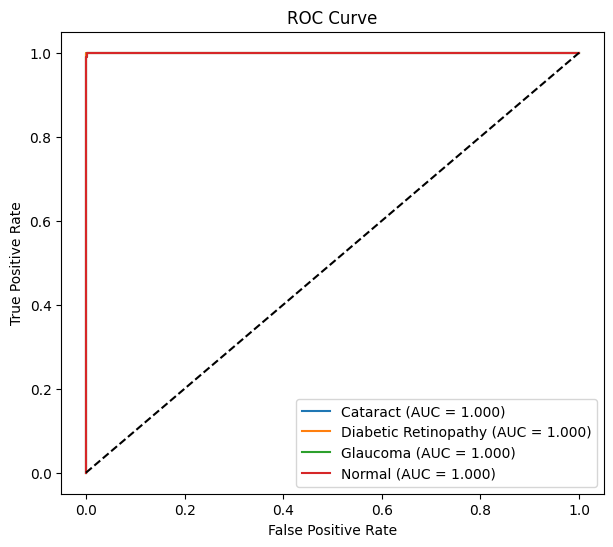

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

plt.figure(figsize=(7,6))

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Classwise Accuracy

In [ ]:
import numpy as np

class_wise_acc = {}

for i, class_name in enumerate(class_names):
    idx = (y_true == i)
    class_acc = np.sum(y_pred[idx] == i) / np.sum(idx)
    class_wise_acc[class_name] = class_acc * 100

for cls, acc in class_wise_acc.items():
    print(f"{cls}: {acc:.2f}%")


Cataract: 100.00%
Diabetic Retinopathy: 100.00%
Glaucoma: 99.02%
Normal: 99.07%


Per Class Accuracy in Barchart Form

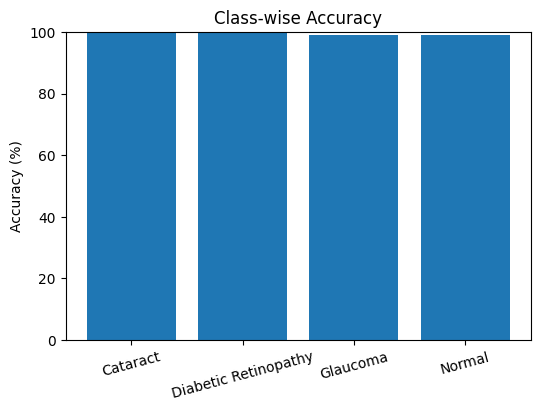

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(class_names, list(class_wise_acc.values()))
plt.ylabel("Accuracy (%)")
plt.title("Class-wise Accuracy")
plt.ylim(0,100)
plt.xticks(rotation=15)
plt.show()

Overall Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

overall_accuracy = accuracy_score(y_true, y_pred) * 100
print(f"Overall Model Accuracy: {overall_accuracy:.2f}%")


Overall Model Accuracy: 99.53%


In [ ]:
overall_accuracy = (y_true == y_pred).sum() / len(y_true) * 100
print(f"Overall Model Accuracy: {overall_accuracy:.2f}%")


Overall Model Accuracy: 99.53%


In [ ]:
test_img = "/content/EyeDataset/dataset/diabetic_retinopathy/1000_left.jpeg"
predict_eye_disease(test_img)

------------------------------
👁️ Image: 1000_left.jpeg
🩺 Prediction: Diabetic Retinopathy
📊 Confidence: 100.00%
------------------------------


('Diabetic Retinopathy', 99.99957084655762)